# Proyecto 5: Análisis de sentimiento en reviews de películas

En este proyecto vamos a trabajar con un dataset de reviews de películas. El objectivo es clasificar cada comentario de acuerdo al sentimiento positivo o negativo hacia la película. Para hacerlo, vamos a trabajar con procesamiento de texto para luego aplicar las diferentes técnicas predictivas que hemos visto.

## Dataset

En primer lugar, carguemos las reviews para comenzar a procesarlas. En este caso no tenemos un archivo `.csv`, sino un directorio estructurado de la siguiente forma: 
```
movie_reviews/
  neg/
  pos/
```
`sklearn` nos provee de la función `load_files` que permite recorrer este tipo de estructuras. 

In [1]:
import pandas as pd
import itertools
import nltk
import re 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'C:\Users\Dotto\Google Drive 2\ACAMICA\ENTREGAS\entrega+5\dataset\movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

Ahora en la variable `movies` tendremos guardadas las reviews (`movies.data`) y su sentimiento (`movies.target`).
Veamos cuantas reviews tenemos en total:

In [2]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2002 reviews, con clases ['neg', 'pos'],


Analizando la estructura de los documentos, veamos como luce una muestra de `movies.data`:

In [3]:
movie_reviews.data[0][:500]

b"by-the-numbers : a film which introduces characters , situations , dilemmas and developments that we've seen before in a parade of other films . \na film which can easily be guessed out by the end of frame number one . \na film which is packed to the cap with predictability , leading to very little tension , excitement , suspense or interest on the part of its paying audience . \nin short , a clich ? -ridden formula film . \nwelcome to my review of the general's daughter . \nplot : an undercover army"

Y ahora, con la propiedad `target` podemos ver la categoría asociada a esta review

In [4]:
movie_reviews.target[0]

0

En este caso es un 0, es decir `neg`.

In [5]:
X=pd.DataFrame()
X['review']=movie_reviews.data
X['review']=X['review'].apply(lambda x: x.decode('utf-8'))
X['sentiment'] = movie_reviews.target
y= X['sentiment']
X.drop(['sentiment'],axis=1,inplace=True)

In [6]:
X.head()

,review
0,by-the-numbers : a film which introduces chara...
1,"with his successful books and movies , michael..."
2,the release of dolores claiborne into wide rel...
3,senseless ( r ) marlon wayans is a very talent...
4,"an 18-foot-high , 43-foot-long dragon is the c..."


In [7]:
y

0       0
1       0
2       1
3       0
4       0
       ..
1997    0
1998    1
1999    1
2000    0
2001    0
Name: sentiment, Length: 2002, dtype: int32

In [8]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()


In [9]:
def prep(review):
    review=re.sub("[^a-zA-Z]"," ",review)
    review=review.lower()
    token=nltk.word_tokenize(review)
    review = [stemmer.stem(word) for word  in token]
    return " ".join(review)
        

## Separando en conjuntos de entrenamiento y de testeo

Antes de comenzar con el entrenamiento de los modelos probando distintos algoritmos para encontrar los mejores modelos, vamos a separar el conjunto de reviews en training y testing. 

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.20, stratify=movie_reviews.target, random_state = 12)

In [11]:
X_train.shape

(1601, 1)

In [12]:
X_test.shape

(401, 1)

In [13]:
y_train.shape

(1601,)

In [14]:
y_test.shape

(401,)

## Preprocesamiento

Para trabajar con texto tenemos que realizar una serie de pasos antes de poder entrenar un modelo. Es decir, buscar la forma de convertir el texto a una representación numérica que pueda ser interpretable por los algoritmos de clasificación. 
Para ello vamos a realizar una serie de pasos.
- Tokenizar el texto
- Convertir a vectores de términos/documentos
- Aplicar tfidf


In [15]:
X_train['clean'] = X_train['review'].apply(prep)
X_test['clean'] = X_test['review'].apply(prep)

In [16]:
X_train.head()

,review,clean
224,i relish those rare opportunities when a talen...,i relish those rare opportun when a talent scr...
64,with a team of 200 graphic artists and animato...,with a team of graphic artist and anim work on...
1888,warning : may contain slight mild spoilers . \...,warn may contain slight mild spoiler rate r fo...
1290,i've noticed something lately that i've never ...,i ve notic someth late that i ve never thought...
433,the obvious reason for producing a sequel to a...,the obviou reason for produc a sequel to an im...


In [17]:
X_test.head()

,review,clean
1368,sometimes i wonder just what the censors are t...,sometim i wonder just what the censor are thin...
489,"i know that "" funnest "" isn't a word . \n "" fu...",i know that funnest isn t a word fun is a noun...
1362,"in the james bond film "" diamonds are forever ...",in the jame bond film diamond are forev tiffan...
1417,"john sayles' "" men with guns "" is about what h...",john sayl men with gun is about what happen to...
484,i've got to admit it . . . \ni'm a huge jim ca...,i ve got to admit it i m a huge jim carrey fan...


Es importante destacar que el `fit` debe hacerse sobre el conjunto de `train` y no sobre el total, ya que `tfidf` tiene en cuenta la frecuencia de aparición de las palabras respecto al total del conjunto. Una vez que usamos el `fit` con el conjunto de entrenamiento podemos aplicar la transformación al conjunto de `test`. 

**1) Vectorizá** los textos para obtener una matriz de términos/documentos utilizando td-idf. 

In [18]:
# Realizá los pasos necesarios para vectorizar los conjuntos de entrenamiento y testeo en este celda
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),sublinear_tf = True,max_features = 40000)
X_train = vectorizer.fit_transform(X_train['clean'])
X_test = vectorizer.transform(X_test['clean'])
print(vectorizer.vocabulary_)

{'relish': 28955, 'rare': 28248, 'opportun': 25317, 'talent': 34155, 'screenwrit': 30665, 'make': 21590, 'feel': 11503, 'like': 20226, 'fool': 12891, 'spent': 32680, 'hour': 16923, 'forc': 12913, 'natur': 24184, 'slowli': 32041, 'stew': 33166, 'grim': 14469, 'attitud': 1982, 'marriag': 22184, 'grous': 14530, 'transpar': 36244, 'plane': 26640, 'train': 36213, 'automobil': 2113, 'plot': 26849, 'machin': 21442, 'wait': 38257, 'inevit': 17555, 'hollywood': 16702, 'denouement': 7906, 'thi': 34675, 'wa': 37902, 'mass': 22236, 'market': 22154, 'romant': 29714, 'comedi': 6190, 'genr': 13598, 'ha': 14714, 'taken': 34144, 'teenag': 34411, 'best': 3046, 'day': 7490, 'work': 39343, 'hard': 15289, 'perpetu': 26289, 'romanc': 29707, 'infatu': 17569, 'paradigm': 25745, 'marc': 22085, 'lawrenc': 19743, 'did': 8184, 'someth': 32282, 'wonder': 39263, 'entir': 10352, 'film': 11692, 'click': 5873, 'place': 26579, 'comic': 6250, 'love': 21230, 'stori': 33248, 'grown': 14541, 'certainli': 4975, 'didn': 8235

In [19]:
X_train

<1601x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 519741 stored elements in Compressed Sparse Row format>

In [20]:
X_test

<401x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 118141 stored elements in Compressed Sparse Row format>

### Dimensión de la matriz de términos
Una vez vectorizados los documentos veamos qué forma tiene la matriz resultante

In [21]:
X_train.shape

(1601, 40000)

In [22]:
X_test.shape

(401, 40000)

__¿ Por qué tiene estas dimensiones ?__

Responder.

Porque el resultado es una matriz de términos por documentos. Por cada término existente en el dataset habrá una columna, ya que no se realizó ningún tipo de filtrado.

## Entrenando los modelos
Una vez que tenemos una matriz con los vectores correspondientes a los documentos luego de aplicarse td-idf podemos comenzar con el proceso de entrenamiento de los modelos. Para eso, vamos a comparar diferentes algoritmos vistos como SVM, Random Forest, AdaBoost, Voting. Y todos los algoritmos complementarios que se quieran introducir. 
Para el entrenamiento de los modelos usaremos GridSearch recorriendo una lista de parámetros según corresponda a cada algoritmo. Además usaremos 5-fold CV y el scoring estará dado por el área bajo la curva roc.

### Support Vector Machines (SVM)

__Ajustar un SVM (kernel lineal) al conjunto de datos de entrenamiento y devolver la matriz de confusión en testing.__

Basándonos en el paper https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, vamos a utilizar un kernel lineal. Al tener menos instancias que features este es el procedimiento recomendado. 

Nuestro espacio de parámetros para recorrer de forma exhaustiva utilizando GridSearch será el siguiente:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 

**2) Entrenar** un modelo utilizando `Grid Search` y el clasificador `LinearSVC` con `5-fold` cross validation y que utilice como `scoring` el área bajo la curva roc.

In [23]:
# Realizá el entrenamiento en esta celda
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'loss':['hinge','squared_hinge']}
clf = LinearSVC()
grid = GridSearchCV(clf, parameters, scoring='roc_auc',cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [24]:
grid.cv_results_

{'mean_fit_time': array([0.00624862, 0.00624242, 0.00625391, 0.01249661, 0.00624871,
        0.01561961, 0.12249498, 0.02296443, 0.0967557 , 0.1509388 ]),
 'std_fit_time': array([7.65296184e-03, 7.64537505e-03, 7.65945450e-03, 6.24833224e-03,
        7.65307864e-03, 2.94174134e-06, 1.17011529e-01, 7.04464535e-03,
        1.15850898e-01, 8.53576932e-03]),
 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.00312572,
        0.        , 0.00392246, 0.00632987, 0.        , 0.        ]),
 'std_score_time': array([0.        , 0.        , 0.        , 0.        , 0.00625143,
        0.        , 0.0058848 , 0.00775358, 0.        , 0.        ]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['hinge', 'squared_hinge', 'hinge', 'squared_hinge',

Veamos los resultados promediados por cada combinación de parámetros:

In [25]:
grid.best_params_

{'C': 1, 'loss': 'hinge'}

In [26]:
optimised_svm = grid.best_estimator_
optimised_svm

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

## Matriz de confusión 
Una forma de ver fácilmente el resultado de un clasificador es utilizando una matriz de confusión. A continuación
se presenta una función para visualizar una matriz de confusión utilizando `matplotlib`.

In [27]:
import numpy as np
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



**3) Mostrá** los resultados de la predicción del clasificador `LinearSVC` sobre el conjunto de test con una matriz de confusión

In [28]:
# Mostrá la matriz de confusión en esta celda
svc = LinearSVC()
svc.fit(X_train,y_train)

print("acc : ",svc.score(X_test,y_test))

acc :  0.8653366583541147


In [29]:
y_test_pred = svc.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
matrix =confusion_matrix(y_test,y_test_pred)
matrix

array([[175,  25],
       [ 29, 172]], dtype=int64)

Normalized confusion matrix
[[0.875      0.125     ]
 [0.14427861 0.85572139]]


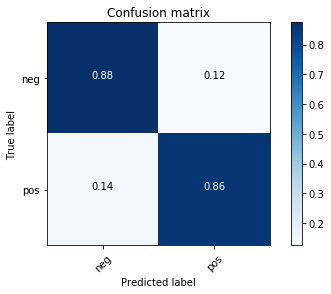

In [31]:
plot_confusion_matrix(matrix,classes=['neg','pos'],normalize=True)

**4) Calcular** el área bajo la curva ROC (AUC) en el conjunto de testing para el modelo y mostrá el `classification_report`

In [32]:
# Mostrá el roc_auc score y el classification_report en esta celda
from sklearn.metrics import roc_auc_score
svc_roc=roc_auc_score(y_test,y_test_pred)
svc_roc

0.8653606965174129

In [33]:
svc_cr=print(classification_report(y_test, y_test_pred))
svc_cr

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       200
           1       0.87      0.86      0.86       201

    accuracy                           0.87       401
   macro avg       0.87      0.87      0.87       401
weighted avg       0.87      0.87      0.87       401



### Random Forests
El siguiente modelo que vamos a entrenar es utilizando la técnica de Random Forest. 

__5) Usando grid search__ con cross validation (5 folds), encontrar el mejor modelo según el AUC dado el siguiente espacio de búsqueda:

* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]

(puede tardar un poco la ejecución dado el tamaño del dataset)

In [34]:
# entrenar el modelo en esta celda
from sklearn.ensemble import RandomForestClassifier
parameters_tree = {'n_estimators':[100, 500, 1000],
              'max_depth': [3, 7, None],
              'min_samples_split': [2, 3, 10],
              'bootstrap': [True, False],
              'criterion': ["gini", "entropy"]}
clf_2 = RandomForestClassifier()
gridtree = GridSearchCV(clf_2,parameters_tree, scoring='roc_auc',cv=5, return_train_score='boolean')
gridtree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Random Forest`. Es decir, mostrar la matriz de confusión, scores, etc

In [35]:
gridtree.cv_results_

{'mean_fit_time': array([ 0.13275452,  0.63522539,  1.25719819,  0.13159394,  0.62958832,
         1.26018505,  0.12897077,  0.62182446,  1.24721189,  0.21406012,
         1.10128551,  2.07167735,  0.20307636,  1.00601277,  2.05267682,
         0.20620203,  0.97916846,  1.94954634,  0.72482338,  3.58040543,
         7.26759648,  0.71857963,  3.57728066,  7.27060595,  0.64360013,
         3.20190754,  6.77054687,  0.15880394,  0.7482028 ,  1.54157672,
         0.15608659,  0.71969376,  1.44100404,  0.15574064,  0.74314156,
         1.41509409,  0.24099426,  1.16534667,  2.32132587,  0.24658699,
         1.21058254,  2.43238139,  0.26700587,  1.19079165,  2.29320869,
         0.86229172,  4.40061173,  8.78232641,  0.86603942,  4.24062877,
         8.56341391,  0.79534488,  3.92572803,  7.79713345,  0.12562165,
         0.59893727,  1.1994988 ,  0.12563066,  0.61099687,  1.20341034,
         0.12443485,  0.60853276,  1.20874906,  0.23685179,  1.13584971,
         2.2714273 ,  0.23145208, 

In [36]:
gridtree.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [37]:
optimised_svm_tree = gridtree.best_estimator_
optimised_svm_tree

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
tree = RandomForestClassifier()
tree.fit(X_train,y_train)

print("acc : ",tree.score(X_test,y_test))

acc :  0.7980049875311721


In [39]:
y_test_pred_tree = tree.predict(X_test)

In [40]:
matrix_tree =confusion_matrix(y_test,y_test_pred_tree)
matrix_tree

array([[174,  26],
       [ 55, 146]], dtype=int64)

Normalized confusion matrix
[[0.87       0.13      ]
 [0.27363184 0.72636816]]


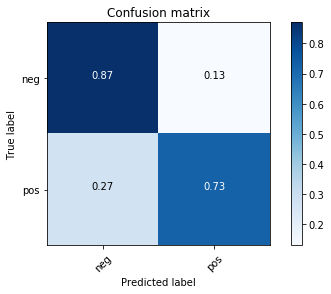

In [41]:
plot_confusion_matrix(matrix_tree,classes=['neg','pos'],normalize=True)

In [42]:
tree_roc=roc_auc_score(y_test,y_test_pred_tree)
tree_roc

0.7981840796019901

In [43]:
tree_cr=print(classification_report(y_test, y_test_pred_tree))
tree_cr

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       200
           1       0.85      0.73      0.78       201

    accuracy                           0.80       401
   macro avg       0.80      0.80      0.80       401
weighted avg       0.80      0.80      0.80       401



### Multilayer Perceptron

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Multilayer Perceptron`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'hidden_layer_sizes': [(10,),(5,5), (2,2)]}`

In [44]:
from sklearn.neural_network import MLPClassifier
parameters_MLPC ={'hidden_layer_sizes':[(10,),(5,5), (2,2)]}
clf_3 = MLPClassifier()
grid_MLPC =GridSearchCV(clf_3,parameters_MLPC,scoring='roc_auc',cv=5, return_train_score='boolean')
grid_MLPC.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

In [45]:
grid_MLPC.cv_results_

{'mean_fit_time': array([11.37356739,  6.02947187,  1.91328225]),
 'std_fit_time': array([0.2467915 , 2.84774518, 0.57855973]),
 'mean_score_time': array([0.00179462, 0.00199385, 0.00119629]),
 'std_score_time': array([0.00039878, 0.0006312 , 0.00039904]),
 'param_hidden_layer_sizes': masked_array(data=[(10,), (5, 5), (2, 2)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': (10,)},
  {'hidden_layer_sizes': (5, 5)},
  {'hidden_layer_sizes': (2, 2)}],
 'split0_test_score': array([0.91762422, 0.91541149, 0.91673137]),
 'split1_test_score': array([0.90882812, 0.89960938, 0.5       ]),
 'split2_test_score': array([0.91527344, 0.9128125 , 0.5       ]),
 'split3_test_score': array([0.90980469, 0.5       , 0.5       ]),
 'split4_test_score': array([0.89808594, 0.89640625, 0.88507813]),
 'mean_test_score': array([0.90992328, 0.82484792, 0.6603619 ]),
 'std_test_score': array([0.00677148, 0.16258879, 0.19665732]),
 

In [46]:
grid_MLPC.best_params_

{'hidden_layer_sizes': (10,)}

In [47]:
optimised_svm_MLPC = grid_MLPC.best_estimator_
optimised_svm_MLPC

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [48]:
MLPC = MLPClassifier()
MLPC.fit(X_train,y_train)

print("acc : ",MLPC.score(X_test,y_test))

acc :  0.85785536159601


In [49]:
y_test_pred_MLPC = MLPC.predict(X_test)

In [50]:
matrix_MLPC =confusion_matrix(y_test,y_test_pred_MLPC)
matrix_MLPC

array([[172,  28],
       [ 29, 172]], dtype=int64)

Normalized confusion matrix
[[0.86       0.14      ]
 [0.14427861 0.85572139]]


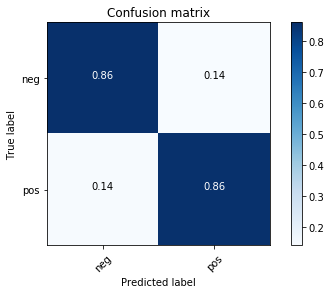

In [51]:
plot_confusion_matrix(matrix_MLPC,classes=['neg','pos'],normalize=True)

In [52]:
MLPC_roc=roc_auc_score(y_test,y_test_pred_MLPC)
MLPC_roc

0.857860696517413

In [53]:
MLPC_cr=print(classification_report(y_test, y_test_pred_MLPC))
MLPC_cr

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       200
           1       0.86      0.86      0.86       201

    accuracy                           0.86       401
   macro avg       0.86      0.86      0.86       401
weighted avg       0.86      0.86      0.86       401



### AdaBoost

**7) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `AdaBoost`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'n_estimators': [50, 100, 500]}`


In [54]:
from sklearn.ensemble import AdaBoostClassifier
parameters_ABC ={'n_estimators': [50, 100, 500]}
clf_4 = AdaBoostClassifier()
grid_ABC =GridSearchCV(clf_4,parameters_ABC,scoring='roc_auc',cv=5, return_train_score='boolean')
grid_ABC.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [50, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='boolean',
             scoring='roc_auc', verbose=0)

In [55]:
grid_ABC.cv_results_

{'mean_fit_time': array([ 1.71163216,  3.38553829, 16.86168871]),
 'std_fit_time': array([0.02923385, 0.01194109, 0.10290689]),
 'mean_score_time': array([0.03113065, 0.05884905, 0.27327971]),
 'std_score_time': array([0.00039284, 0.00063271, 0.00568612]),
 'param_n_estimators': masked_array(data=[50, 100, 500],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 500}],
 'split0_test_score': array([0.83779115, 0.82915373, 0.85271739]),
 'split1_test_score': array([0.8640625 , 0.87128906, 0.8796875 ]),
 'split2_test_score': array([0.85441406, 0.88984375, 0.86765625]),
 'split3_test_score': array([0.83378906, 0.84636719, 0.87472656]),
 'split4_test_score': array([0.81576172, 0.79851562, 0.85140625]),
 'mean_test_score': array([0.8411637 , 0.84703387, 0.86523879]),
 'std_test_score': array([0.0167985 , 0.03192229, 0.01142586]),
 'rank_test_score': array([3, 2, 1]),
 'spl

In [56]:
grid_ABC.best_params_

{'n_estimators': 500}

In [57]:
optimised_svm_ABC = grid_ABC.best_estimator_
optimised_svm_ABC

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=None)

In [58]:
ABC = AdaBoostClassifier()
ABC.fit(X_train,y_train)

print("acc : ",ABC.score(X_test,y_test))

acc :  0.7630922693266833


In [59]:
y_test_pred_ABC = ABC.predict(X_test)

In [60]:
matrix_ABC =confusion_matrix(y_test,y_test_pred_ABC)
matrix_ABC

array([[162,  38],
       [ 57, 144]], dtype=int64)

Normalized confusion matrix
[[0.81       0.19      ]
 [0.28358209 0.71641791]]


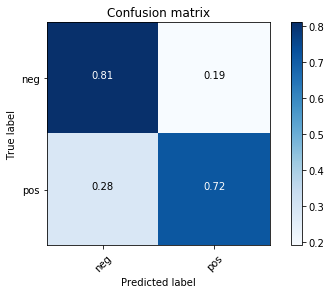

In [61]:
plot_confusion_matrix(matrix_ABC,classes=['neg','pos'],normalize=True)

In [62]:
ABC_roc=roc_auc_score(y_test,y_test_pred_ABC)
ABC_roc

0.7632089552238805

In [63]:
ABC_cr=print(classification_report(y_test, y_test_pred_ABC))
ABC_cr

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       200
           1       0.79      0.72      0.75       201

    accuracy                           0.76       401
   macro avg       0.77      0.76      0.76       401
weighted avg       0.77      0.76      0.76       401



__8) Armar un ensamble entre los cuatro modelos usando votación y medir el accuracy de cada uno de los modelos.__


In [64]:
from sklearn.metrics import accuracy_score

In [65]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('SVC',clf), ('RFC',clf_2),('MLPC',clf_3),('ABC',clf_4)],voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('SVC',
                              LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0)),
                             ('RFC',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='a...
                                            momentum=0.9, n_iter_no_chang

In [66]:
for cl in (clf, clf_2,clf_3,clf_4, voting_clf):
    cl.fit(X_train, y_train)
    y_pred_v = cl.predict(X_test)
    print(cl.__class__.__name__, accuracy_score(y_test, y_pred_v))

LinearSVC 0.8653366583541147
RandomForestClassifier 0.8179551122194514
MLPClassifier 0.8503740648379052
AdaBoostClassifier 0.7630922693266833
VotingClassifier 0.85785536159601


In [67]:
#Se puede ver que el modelo mas preciso es el Multilayer Perceptron 

__9) Seleccioná el modelo__ que te haya dado el mejor score y utilizalo como tu modelo final. Reentrenalo con todos tus datos de entrenamiento.


In [68]:
# ´X´ es el dataset completo

In [69]:
X['clean'] = X['review'].apply(prep)

In [70]:
X = vectorizer.fit_transform(X['clean'])

In [71]:
clf_X = MLPClassifier()
grid_MLPC_X =GridSearchCV(clf_X,parameters_MLPC,scoring='roc_auc',cv=5, return_train_score='boolean')
grid_MLPC_X.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

In [72]:
MLPC_X = MLPClassifier()
MLPC_X.fit(X,y)

print("acc : ",MLPC_X.score(X,y))

acc :  0.9995004995004995


In [73]:
# Guardamos el modelo
from sklearn.externals import joblib
joblib.dump(clf_X, 'sentiment.pkl') 

['sentiment.pkl']

## Clasificación de reviews de Rocky 4.

A partir de [criticas de la película Rocky 4](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user) veamos como las clasifica nuestro mejor modelo

In [74]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = vectorizer.transform(reviews_new)
reviews_new_tfidf = vectorizer.transform(reviews_new)